# <center> Tutorial - Extracting info from OpenStreetMap </center>

Thomas de Mareuil - Total E-Lab

In this notebook, we explore several ways to download, manipulate and plot OSM data. We work with points and polygons using `shapely`, `geopandas` and `geojson`, and we plot interactive maps with `folium` and `geojsonio`.

The data we use throughout the notebook is solar tags information from OSM in Belgium (1st section), and forests polygons in the French department of Jura (2nd section). The extracted data could then potentially be used to download corresponding satellite image tiles. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
import geojsonio
from geojson import Point, Feature, FeatureCollection, dump
from shapely.geometry import Polygon, Point, asShape, mapping, shape
import requests
import os
import pickle

## Query from notebook

We can query OSM data directly from a notebook by using a custom function which calls the Overpass API, downloads raw OSM data and writes a pickle file in the specified folder. We can then plot the data and go through preliminary analysis.

#### Query

In this example, the function downloads solar tags information, in any selected country (to run locally, make sure you specify the right folder and file names).

In [2]:
def getSolarPanelsFromOSM(country="country", read_from_pickle=False, pickle_read_name=None, 
                          pickle_write_name="osm_panels", folder_with_output_files='data'):
    
    print("Query Open Street Map for solar panels in {}.".format(country))
    
    # either load pickle data or query overpass
    dirname = '../Data'
    if read_from_pickle:
        with open(os.path.join(dirname, folder_with_output_files, pickle_read_name + ".pkl"), 'rb') as f:
             osm_queried_panels = pickle.load(f)
    else:
        overpass_url = "http://overpass-api.de/api/interpreter"

        # query all solar panels saved as polygon
        solar_ways_query = """
            [out:json];
            area["int_name"="{}"]->.searchArea;
            (
            way(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
            );
            out body;
            >;
            out skel qt;
        """.format(country)
        ways_solar = requests.get(overpass_url, params={'data': solar_ways_query}).json()
        
        # to simplify, one polygon = one panel, and panel will get coordinates of the first node of polygon
        first_node_ids = [element["nodes"][0] for element in ways_solar["elements"] if element["type"] == "way"]
        panels_from_polygon = [element for element in ways_solar["elements"] if element["id"] in first_node_ids]

        # query all solar panels saved as points (nodes)
        solar_nodes_query = """
            [out:json];
            area["int_name"="{}"]->.searchArea;
            (
             node(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
            );
            out body;
            >;
            out skel qt;
        """.format(country)
        panels_from_nodes = requests.get(overpass_url, params={'data': solar_nodes_query}).json()

        osm_queried_panels = panels_from_nodes["elements"] + panels_from_polygon
        osm_queried_panels = ways_solar['elements'] # we assign osm_queried_panels twice?

        with open(os.path.join(dirname, folder_with_output_files, pickle_write_name + ".pkl"), 'wb') as f:
            pickle.dump(osm_queried_panels, f)
    print("Done.")

    return osm_queried_panels

In [3]:
osm_pv_be = getSolarPanelsFromOSM(country="Belgium", read_from_pickle=True, pickle_read_name='be_panels', 
                                  pickle_write_name="be_panels", folder_with_output_files='OSM_coord')

Query Open Street Map for solar panels in Belgium.
Done.


In [4]:
# Convert to dataframe
osm_df_be = pd.DataFrame(osm_pv_be)
osm_df_be.head(1)

type        id                                              nodes  \
0  way  87681545  [1019715353, 1019715365, 1019715349, 101971536...   

                                                tags  lat  lon  
0  {'building': 'yes', 'generator:method': 'photo...  NaN  NaN

In [5]:
# Count nb of nodes and ways
print(len(osm_df_be))
print(osm_df_be.groupby('type').count())

3850
        id  nodes  tags   lat   lon
type                               
node  3194      0     0  3194  3194
way    656    656   656     0     0


In [6]:
# Convert to geo dataframe
osm_df_be['geometry'] = list(zip(osm_df_be['lon'], osm_df_be['lat']))
osm_df_be['geometry'] = osm_df_be['geometry'].apply(lambda x: Point(x))
osm_df_be = gpd.GeoDataFrame(osm_df_be, crs={'init': 'epsg:4326'}) # OSM comes in this coordinate system
osm_df_be.head(1)

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


type        id                                              nodes  \
0  way  87681545  [1019715353, 1019715365, 1019715349, 101971536...   

                                                tags  lat  lon  \
0  {'building': 'yes', 'generator:method': 'photo...  NaN  NaN   

          geometry  
0  POINT (nan nan)

#### Plot nodes (static)

To plot points on a static map, you can download country shapefiles from: http://www.diva-gis.org/gdata, and plot points using `geopandas`.

In [7]:
# Grab BE outline
be_outline = gpd.read_file('../Data/OSM_coord/BEL_adm/BEL_adm1.shp')

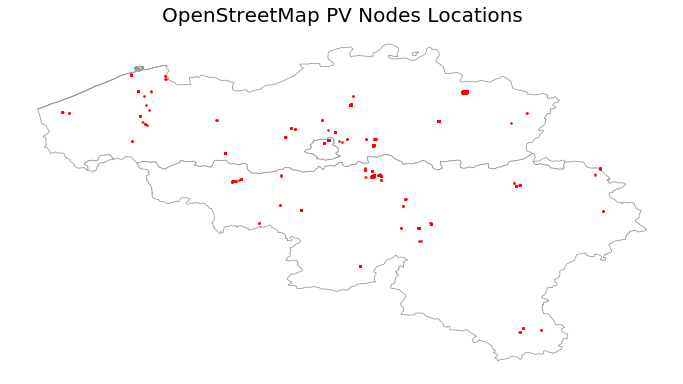

In [10]:
# Plot
fig, ax = plt.subplots(1, figsize=(12, 12))
be_outline.plot(ax=ax, color='white', linewidth=0.8, edgecolor='0.6')
osm_df_be.plot(ax=ax, markersize=2, color='red', alpha=0.4)

ax.set_title("OpenStreetMap PV Nodes Locations", fontdict={'fontsize': '20', 'fontweight' : '3'})
ax.axis('off')
plt.show()

#### Plot nodes (interactive)

You can also plot an interactive map using `folium`.

In [8]:
# Store all nodes coordinates for plotting
osm_folium_be = osm_df_be[osm_df_be.lat.notna()]
print(len(osm_folium_be))
osm_folium_be.head(1)

3194


type          id nodes tags        lat       lon  \
656  node  6139462810   NaN  NaN  49.680877  5.605361   

                     geometry  
656  POINT (5.60536 49.68088)

In [12]:
# Check out map
m = folium.Map([50.5, 4.6], zoom_start=6, tiles='cartodbpositron')

locations = []
popups = []
for idx, row in osm_folium_be.iterrows():
    locations.append([row['geometry'].y, row['geometry'].x])
    popups.append((row['geometry'].y, row['geometry'].x))
    
s = folium.FeatureGroup(name='Solar PV')
s.add_child(MarkerCluster(locations=locations, popups=popups))
m.add_child(s)
m.add_child(folium.LatLngPopup()) # this allow to show lat and lng on click!

Remark: the default map in `folium` is OSM. In the map above, we tuned the map with the `tiles='cartodbpositron'` argument.

We can also add any other map tile as a new layer with the `TileLayer` method. For example, in the map below, we can switch between OSM default map and the free ESRI satellite map (with the proper key, we could also add Mapbox, or GoogleEarthEngine map tiles).

In [12]:
# Create map, with default OSM tile layer
m = folium.Map([50.5, 4.6], zoom_start=6)

# Add markers
locations = []
popups = []
for idx, row in osm_folium_be.iterrows():
    locations.append([row['geometry'].y, row['geometry'].x])
    popups.append((row['geometry'].y, row['geometry'].x))
    
s = folium.FeatureGroup(name='Solar PV')
s.add_child(MarkerCluster(locations=locations, popups=popups))
m.add_child(s)
m.add_child(folium.LatLngPopup())

# Add satellite layer
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# Add layer control toggle
# We can control the display of both tile layers and overlay figures
folium.LayerControl().add_to(m)
m

#### Re-build polygon from several points

This method to query OSM only outputs points, but we can re-build polygons based on point coordinates.

In [13]:
# Getting only ways from OSM
osm_pv_be = getSolarPanelsFromOSM(country="Belgium", read_from_pickle=True, pickle_read_name="be_panels", 
                               pickle_write_name="be_panels", folder_with_output_files='OSM_coord')
osm_df_be = pd.DataFrame(osm_pv_be)
ways_be = osm_df_be[osm_df_be.type=='way']
ways_be.head(3)

Query Open Street Map for solar panels in Belgium.
Done.


type         id                                              nodes  \
0  way   87681545  [1019715353, 1019715365, 1019715349, 101971536...   
1  way  104203306  [1202324836, 3014749369, 1202324682, 120232480...   
2  way  132022152  [1452654142, 1452654143, 1452654150, 145265415...   

                                                tags  lat  lon  
0  {'building': 'yes', 'generator:method': 'photo...  NaN  NaN  
1  {'area': 'yes', 'generator:method': 'photovolt...  NaN  NaN  
2  {'generator:method': 'photovoltaic', 'generato...  NaN  NaN

In [14]:
# obtain shape coordinates of all solar ways

def get_coord(solar_way_to_search, full_data_extract):
    summits = list()
    for node in solar_way_to_search:
        node_search = full_data_extract['id'] == node
        node_coords = full_data_extract[node_search]['lon'].append(full_data_extract[node_search]['lat']).values
        summits.append(list(node_coords))
    return summits

all_shapes_be = [get_coord(ways_be['nodes'][i], osm_df_be) for i in range(len(ways_be))]

In [15]:
# convert shape coordinates to shapely polygons and to geodataframe
ways_be['geometry'] = all_shapes_be
ways_be['geometry'] = ways_be['geometry'].apply(lambda x: Polygon(x)) # convert to shapely Polygon
ways_be = gpd.GeoDataFrame(ways_be, crs={'init': 'epsg:4326'}) # convert to geodataframe
ways_be = ways_be.drop(columns=['lat', 'lon'])
ways_be.head(1)

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<

type        id                                              nodes  \
0  way  87681545  [1019715353, 1019715365, 1019715349, 101971536...   

                                                tags  \
0  {'building': 'yes', 'generator:method': 'photo...   

                                            geometry  
0  POLYGON ((5.04290 50.36790, 5.04305 50.36805, ...

In [16]:
# get x and y coord of centroids based on Polygon
ways_for_json_be = ways_be
ways_for_json_be["centroid_lon"] = ways_for_json_be['geometry'].centroid.x
ways_for_json_be["centroid_lat"] = ways_for_json_be['geometry'].centroid.y
ways_for_json_be.head(1)

type        id                                              nodes  \
0  way  87681545  [1019715353, 1019715365, 1019715349, 101971536...   

                                                tags  \
0  {'building': 'yes', 'generator:method': 'photo...   

                                            geometry  centroid_lon  \
0  POLYGON ((5.04290 50.36790, 5.04305 50.36805, ...      5.043307   

   centroid_lat  
0     50.367861

#### Plot polygons (interactive)

Another plotting method for geographic data is `geojsonio`, which takes a geojson file as input and plots it in the browser. Note that we only plot the first 200 panels, if we try to plot a too big file `geojsonio` tries to create a gist on GitHub and requires authentification.

In [ ]:
# convert to json and write to disk
ways_for_json_be_full = ways_for_json_be.to_json()
with open('../Data/OSM_coord/be_panels.geojson', 'w') as f:
    dump(ways_for_json_be_full, f)
print('Successfully wrote a json file with all solar ways shapes and centroid coordinates.')

In [17]:
# visualise geojson in browser
ways_for_json_plot_be = ways_for_json_be.head(200).to_json()
geojsonio.display(ways_for_json_plot_be)

'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22id%22%3A%20%220%22%2C%20%22type%22%3A%20%22Feature%22%2C%20%22properties%22%3A%20%7B%22centroid_lat%22%3A%2050.36786055876561%2C%20%22centroid_lon%22%3A%205.043306940920206%2C%20%22id%22%3A%2087681545%2C%20%22nodes%22%3A%20%5B1019715353%2C%201019715365%2C%201019715349%2C%201019715366%2C%201019715351%2C%201019715350%2C%201019715353%5D%2C%20%22tags%22%3A%20%7B%22building%22%3A%20%22yes%22%2C%20%22generator%3Amethod%22%3A%20%22photovoltaic%22%2C%20%22generator%3Aoutput%3Aelectricity%22%3A%20%22yes%22%2C%20%22generator%3Aplace%22%3A%20%22roof%22%2C%20%22generator%3Asource%22%3A%20%22solar%22%2C%20%22generator%3Atype%22%3A%20%22solar_photovoltaic_panel%22%2C%20%22name%22%3A%20%22Ecomarch%5Cu00e9%20Assesse%22%2C%20%22power%22%3A%20%22generator%22%2C%20%22shop%22%3A%20%22supermarket%22%7D%2C%20%22type%22%3A%20%22way%22%7D%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Po

## Query the online interface

To query OSM data, we can also use the online interface, on https://overpass-turbo.eu. The advantage is that we can dowload directly a clean geojson file. 

#### Query

Below are 2 requests, for needleleaved forests in the French department of Jura (1st request is just a little faster).

In [ ]:
"""
/*
This shows all forests with the "needleleaved" tag in the French Deprtment of Jura.
*/
[out:json];
area["border_type"="departement"]["name"="Jura"]->.searchArea;
(
  way(area.searchArea)
  ["landuse"="forest"]
  ['leaf_type'='needleleaved'];
);
out body;
>;
out skel qt;
"""

In [ ]:
"""
/*
This shows all forests with the "needleleaved" tag in the French Deprtment of Jura.
*/
[out:json];
// search the "relation" corresponding to Jura
rel
  ["border_type"="departement"]
  ["name"="Jura"];
// show the outline
out geom;
// turn the relation into an area
map_to_area;
// get all needleleaved forests in the area
way
  ["landuse"="forest"]
  ['leaf_type'='needleleaved']
  (area);
out body;
>;
out skel qt;
"""

Si vous changez la requête, attention de choisir les bons tags ("name", etc.). Vous pouvez vérifier les termes exacts en cherchant sur le site d'OpenStreetMap (exemple [ici](https://www.openstreetmap.org/relation/7460)).

In [18]:
export = gpd.read_file('/Users/Thomas/Downloads/export.geojson') # choisissez le bon chemin de fichier
print("Ce fichier contient les coordonnées de {} forêts d'épineux dans le Jura.".format(export.shape[0]))

Ce fichier contient les coordonnées de 2935 forêts d'épineux dans le Jura.


In [19]:
# Première ligne du fichier
export.head(1)

id           @id CLC:code     CLC:id CLC:year landuse  \
0  way/42037565  way/42037565      312  FR-118380     2006  forest   

      leaf_type                                             source leaf_cycle  \
0  needleleaved  Union européenne - SOeS, CORINE Land Cover, 2006.       None   

   name natural source:name produce  type  \
0  None    None        None    None  None   

                                            geometry  
0  POLYGON ((5.83316 46.63601, 5.83483 46.63456, ...

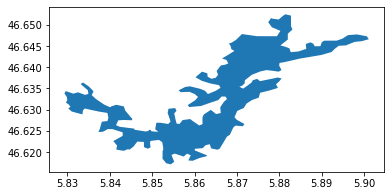

In [20]:
# Afficher la première zone de forêt
export[0:1].plot()
plt.show()

#### Data analysis: compute surface and distribution

To compute polygon surfaces, we convert them to a cartesian coordinate system, preferably ESPG:2154 for France.

In [21]:
# Convertissons en référentiel cartésien (EPSG:2154, unit=m) et calculons les surfaces             
export2 = export.copy()
export2 = export2.to_crs({'init': 'epsg:2154'})
export2["area"] = export2['geometry'].area
export2.head(1)

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


id           @id CLC:code     CLC:id CLC:year landuse  \
0  way/42037565  way/42037565      312  FR-118380     2006  forest   

      leaf_type                                             source leaf_cycle  \
0  needleleaved  Union européenne - SOeS, CORINE Land Cover, 2006.       None   

   name natural source:name produce  type  \
0  None    None        None    None  None   

                                            geometry          area  
0  POLYGON ((916686.075 6618992.467, 916819.629 6...  4.487505e+06

The cells below compute the distribution of forests depending on their surface. Thresholds can be modified.

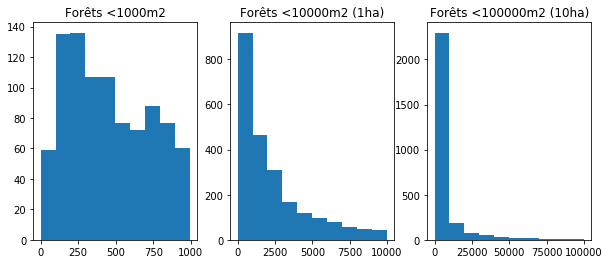

In [22]:
# Observons la répartition
f, ax = plt.subplots(1, 3, figsize=(10,4)) 
ax[0].hist(export2[export2['area'] < 1000]['area'])
ax[1].hist(export2[export2['area'] < 10000]['area'])
ax[2].hist(export2[export2['area'] < 100000]['area'])
ax[0].set_title('Forêts <1000m2')
ax[1].set_title('Forêts <10000m2 (1ha)')
ax[2].set_title('Forêts <100000m2 (10ha)')
plt.show()

In [42]:
inf_1000m2 = export2[export2['area'] < 1000]
print("Nous avons {} forêts d'épineux <1000m2.".format(inf_1000m2.shape[0]))

Nous avons 918 forêts d'épineux <1000m2.


In [43]:
inf_1ha = export2[export2['area'] < 10000]
print("Nous avons {} forêts d'épineux <1ha.".format(inf_1ha.shape[0]))

Nous avons 2297 forêts d'épineux <1ha.


In [44]:
inf_10ha = export2[export2['area'] < 100000]
print("Nous avons {} forêts d'épineux <10ha.".format(inf_10ha.shape[0]))

Nous avons 2717 forêts d'épineux <10ha.


In [23]:
intermediate = export2[(export2['area'] > 10000) & (export2['area'] < 100000)]
print("Nous avons {} forêts d'épineux entre 1ha et 10ha.".format(intermediate.shape[0]))

Nous avons 420 forêts d'épineux entre 1ha et 10ha.


#### Write new filtered file

En fonction des forêts dont vous avez besoin, après les avoir filtré (section précédentes) il est possible d'enregistret un nouveau fichier. A nouveau, attention au choix du chemin et du nom de fichier.

In [46]:
# convertir au format geojson
intermediate = intermediate.to_crs({'init': 'epsg:4326'})
export_filtered = intermediate.to_json()

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [47]:
# écriture du fichier
with open('/Users/Thomas/Downloads/export_filtered.geojson', 'w') as f:
    dump(export_filtered, f)
print("Nouveau fichier bien enregistré.")

Nouveau fichier bien enregistré.


#### Plot polygons (interactive)

Folium can be used to plot the selected polygons.

In [24]:
# Représentation sur carte des forêts entre 1ha et 10ha

m = folium.Map([46.6, 5.8], zoom_start=9)

# afficher polygones
folium.GeoJson(intermediate).add_to(m)

# afficher marqueurs avec surface polygone et coordonnées centre
locations = []
popups = []
for idx, row in intermediate.iterrows():
    locations.append([row['geometry'].centroid.y, row['geometry'].centroid.x])
    popups.append("area: {} m2, centroid coord: {}".format(round(row['area'],1), 
                                                  (round(row['geometry'].centroid.y,1), 
                                                   round(row['geometry'].centroid.x,1))))
s = folium.FeatureGroup(name='Forêts <10000m2')
s.add_child(MarkerCluster(locations=locations, popups=popups))
m.add_child(s)

m